In [1]:
import os

import dill

import matplotlib.pyplot as plt
import torch
import pyro
import copy

import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import numpy as np

import torch
import time

import pandas as pd
from torch.utils.data import DataLoader

from chirho.indexed.ops import IndexSet, gather
import seaborn as sns


import pyro
from pyro.infer import Predictive

from chirho.counterfactual.handlers import MultiWorldCounterfactual

# from cities.modeling.zoning_models.units_causal_model import UnitsCausalModel
from cities.modeling.zoning_models.distance_causal_model import DistanceCausalModel
from cities.modeling.svi_inference import run_svi_inference
from cities.utils.data_loader import select_from_data


from pyro.infer.autoguide import AutoDiagonalNormal

from cities.modeling.evaluation import (
    prep_data_for_test,
    test_performance,
)

from cities.modeling.svi_inference import run_svi_inference
from pyro.infer import Predictive
from chirho.observational.handlers.predictive import PredictiveModel
from chirho.interventional.handlers import do


smoke_test = "CI" in os.environ

# use when testing model health
# smoke_test = True

n_steps = 10 if smoke_test else 1500
num_samples = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [2]:
start = time.time()

zoning_data_path = os.path.join(root, "data/minneapolis/processed/zoning_dataset.pt")

zoning_dataset_read = torch.load(zoning_data_path)

zoning_loader = DataLoader(
    zoning_dataset_read, batch_size=len(zoning_dataset_read), shuffle=True
)

data = next(iter(zoning_loader))

kwargs = {
    "categorical": [
        "year",
        "month",
        "zone_id",
        "neighborhood_id",
        "ward_id",
        "past_reform",
    ],
    "continuous": {
        "limit_con",
        "parcel_area",
        "distance_to_transit_original",
        "distance_to_transit",
    },
    "outcome": "housing_units",
}

subset = select_from_data(data, kwargs)

subset_no_outcome = copy.deepcopy(subset)
subset_no_outcome["outcome"] = None

distance_model = DistanceCausalModel(
    **subset, categorical_levels=zoning_dataset_read.categorical_levels
)

In [3]:
pyro.clear_param_store()

guide_path = os.path.join(root, "data/minneapolis/guides", "distance_model_guide.pkl")

param_path = os.path.join(root, "data/minneapolis/guides", "distance_model_params.pth")

with open(guide_path, "rb") as file:
    guide = dill.load(file)

pyro.get_param_store().load(param_path)

predictive = Predictive(
    model=distance_model, guide=guide, num_samples=num_samples, parallel=True
)

Index(['parcel', 'date', 'neighborhood', 'ward', 'downtown_yn',
       'housing_units', 'car_parking', 'bike_parking', 'parcel_area',
       'university_yn', 'res_parking_elim_2015_yn',
       'res_parking_reduced_2015_yn', 'distance_to_transit', 'census_tract',
       'year', 'year_id', 'month', 'day', 'past_reform', 'limit', 'limit_id',
       'limit_con', 'zone', 'zone_id', 'month_id', 'day_id', 'neighborhood_id',
       'ward_id', 'parcel_id', 'census_tract_id', 'housing_units_std',
       'car_parking_std', 'parcel_area_std', 'distance_to_transit_std'],
      dtype='object')


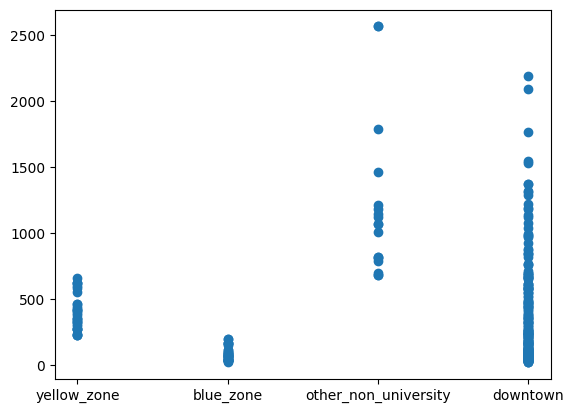

658.8828117577909
2563.953630937824


(array([168.,  52.,  39.,  16.,  14.,   7.,   2.,   0.,   2.,   2.]),
 array([  17.38316164,  272.04020857,  526.6972555 ,  781.35430243,
        1036.01134936, 1290.66839629, 1545.32544322, 1799.98249015,
        2054.63953708, 2309.29658401, 2563.95363094]),
 <BarContainer object of 10 artists>)

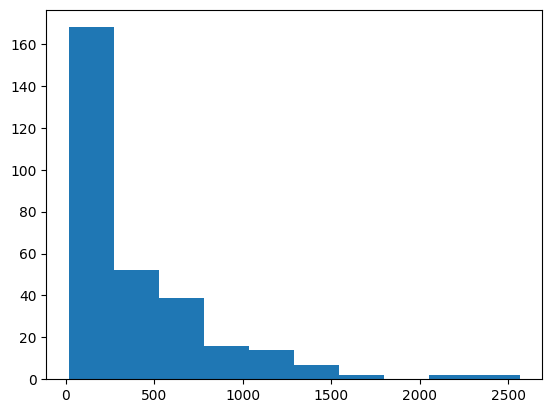

In [4]:
zoning = pd.read_csv(
    os.path.join(root, "data/minneapolis/processed/zoning_expanded.csv")
)
print(zoning.columns)

downtown = zoning["zone_id"] == 0
blue = zoning["zone_id"] == 1
yellow = zoning["zone_id"] == 2

plt.scatter(x=zoning["zone"], y=zoning["distance_to_transit"])
plt.show()


print(max(zoning["distance_to_transit"][zoning["zone_id"] == 2]))

print(max(zoning["distance_to_transit"]))

plt.hist(zoning["distance_to_transit"])

In [5]:
required_for_intervention = zoning[
    [
        "past_reform",
        "limit_con",
        "zone",
        "zone_id",
        "distance_to_transit",
        "day",
        "day_id",
    ]
]

required_for_intervention.to_csv(
    os.path.join(
        root, "data/minneapolis/processed/zoning_required_for_intervention.csv"
    )
)

In [6]:
required_for_intervention = pd.read_csv(
    os.path.join(
        root, "data/minneapolis/processed/zoning_required_for_intervention.csv"
    )
)


def zoning_intervention(data, radius_blue, limit_blue, radius_yellow, limit_yellow):

    assert radius_blue < radius_yellow

    data = data.copy()

    intervention = data["limit_con"].copy()

    downtown = data["zone_id"] == 0
    past_reform = data["past_reform"]

    # TODO potentially allow for interventions starting at other times by modifying past past_reform above

    new_blue = (~downtown) & past_reform & (data["distance_to_transit"] <= radius_blue)
    new_yellow = (
        (~downtown)
        & past_reform
        & (data["distance_to_transit"] > radius_blue)
        & (data["distance_to_transit"] <= radius_yellow)
    )
    new_other = (
        (~downtown) & past_reform & (data["distance_to_transit"] > radius_yellow)
    )

    intervention[downtown] = 0.0
    intervention[new_blue] = limit_blue
    intervention[new_yellow] = limit_yellow
    intervention[new_other] = 1.0
    return intervention


simple_intervention = zoning_intervention(required_for_intervention, 200, 0.5, 700, 0.8)

In [7]:
intervention_tensor = torch.tensor(simple_intervention).float()

with MultiWorldCounterfactual() as mwc:
    with do(actions={"limit_con": intervention_tensor}):
        samples = predictive(**subset_no_outcome)

In [8]:
n = 302
distance_interval = 200
distance_max = 2000
# 2600 is almost max in data
dist = np.arange(0, distance_max, distance_interval)
dist = dist.round()  # to avoid small numerical issues
n_dist = len(dist)

limit_interval = 0.1
lim = np.arange(0, 1.01, limit_interval)
print(lim)
lim = lim.round(decimals=1)
n_lim = len(lim)


interventions_list = []
interventions_settings_dict = {}
counter = 0
for d_blue in dist:
    for l_blue in lim:
        for d_yellow in dist[dist > d_blue]:  # note the built in restriction
            for l_yellow in lim:
                counter += 1
                interventions_settings_dict[(d_blue, l_blue, d_yellow, l_yellow)] = (
                    counter
                )

                interventions_values = zoning_intervention(
                    required_for_intervention,
                    radius_blue=d_blue,
                    limit_blue=l_blue,
                    radius_yellow=d_yellow,
                    limit_yellow=l_yellow,
                )

                interventions_list.append(torch.tensor(interventions_values).float())

interventions_tuple = tuple(interventions_list)


print(counter)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
5445


torch.Size([1000, 5446, 1, 1, 1, 302])


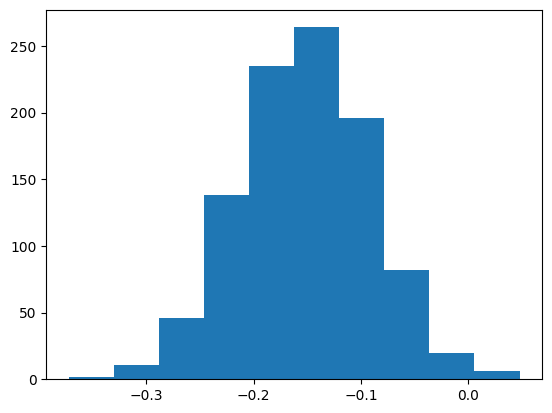

In [9]:
with MultiWorldCounterfactual() as mwc:
    with do(actions={"limit_con": interventions_tuple}):
        samples = predictive(**subset_no_outcome)


print(samples["housing_units"].shape)

plt.hist(samples["weight_continuous_limit_con_housing_units_"].flatten())
plt.show()

In [10]:
predicted_means = {}

with mwc:

    value = samples["housing_units"]

    factual_preds = (
        gather(value, IndexSet(**{"limit_con": {0}}), event_dims=0)
        .squeeze()
        .detach()
        .mean(axis=0)
        .numpy()
    )

    for setting, world in interventions_settings_dict.items():

        predicted_means[setting] = (
            gather(value, IndexSet(**{"limit_con": {world}}), event_dims=0)
            .squeeze()
            .detach()
            .mean(axis=0)
            .numpy()
        )

dict_keys([(0, 0.0, 200, 0.0), (0, 0.0, 200, 0.1), (0, 0.0, 200, 0.2), (0, 0.0, 200, 0.3), (0, 0.0, 200, 0.4), (0, 0.0, 200, 0.5), (0, 0.0, 200, 0.6), (0, 0.0, 200, 0.7), (0, 0.0, 200, 0.8), (0, 0.0, 200, 0.9), (0, 0.0, 200, 1.0), (0, 0.0, 400, 0.0), (0, 0.0, 400, 0.1), (0, 0.0, 400, 0.2), (0, 0.0, 400, 0.3), (0, 0.0, 400, 0.4), (0, 0.0, 400, 0.5), (0, 0.0, 400, 0.6), (0, 0.0, 400, 0.7), (0, 0.0, 400, 0.8), (0, 0.0, 400, 0.9), (0, 0.0, 400, 1.0), (0, 0.0, 600, 0.0), (0, 0.0, 600, 0.1), (0, 0.0, 600, 0.2), (0, 0.0, 600, 0.3), (0, 0.0, 600, 0.4), (0, 0.0, 600, 0.5), (0, 0.0, 600, 0.6), (0, 0.0, 600, 0.7), (0, 0.0, 600, 0.8), (0, 0.0, 600, 0.9), (0, 0.0, 600, 1.0), (0, 0.0, 800, 0.0), (0, 0.0, 800, 0.1), (0, 0.0, 800, 0.2), (0, 0.0, 800, 0.3), (0, 0.0, 800, 0.4), (0, 0.0, 800, 0.5), (0, 0.0, 800, 0.6), (0, 0.0, 800, 0.7), (0, 0.0, 800, 0.8), (0, 0.0, 800, 0.9), (0, 0.0, 800, 1.0), (0, 0.0, 1000, 0.0), (0, 0.0, 1000, 0.1), (0, 0.0, 1000, 0.2), (0, 0.0, 1000, 0.3), (0, 0.0, 1000, 0.4), (0, 

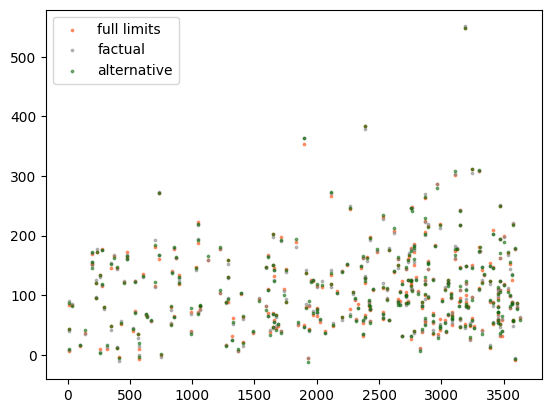

In [15]:
class PermitPredictor:
    def __init__(
        self,
        distance_interval,
        distance_max,
        limit_interval,
        zone,
        zone_id,
        day,
        factual_preds,
        predicted_means,
    ):

        self.distance_interval = distance_interval
        self.distance_max = distance_max
        self.limit_interval = limit_interval

        self.zone = zone
        self.zone_id = zone_id
        self.day = day

        self.outcome_mean = zoning_dataset_read.standardization_dictionary[
            "housing_units"
        ]["mean"]
        self.outcome_sd = zoning_dataset_read.standardization_dictionary[
            "housing_units"
        ]["std"]

        self.factual_preds = factual_preds
        self.factual_preds_destandardized = self.destandardize_housing_units(
            self.factual_preds
        )
        self.predicted_means = predicted_means

    def predict(self, d_blue, l_blue, d_yellow, l_yellow):
        return self.predicted_means[(d_blue, l_blue, d_yellow, l_yellow)]

    def destandardize_housing_units(self, column):
        return (column * self.outcome_sd + self.outcome_mean).round()

    def predict_destandardized(self, d_blue, l_blue, d_yellow, l_yellow):
        return self.destandardize_housing_units(
            self.predicted_means[(d_blue, l_blue, d_yellow, l_yellow)]
        )


permit_predictor = PermitPredictor(
    distance_interval,
    distance_max,
    limit_interval,
    required_for_intervention["zone"],
    required_for_intervention["zone_id"],
    required_for_intervention["day"],
    factual_preds,
    predicted_means,
)


print(permit_predictor.predicted_means.keys())
factual = permit_predictor.factual_preds_destandardized
full = permit_predictor.predict_destandardized(400, 1.0, 1400, 1.0)

print(permit_predictor.predicted_means.keys())
alternative = permit_predictor.predict_destandardized(400, 0.0, 1400, 0.0)

print(factual.shape)


print(min(permit_predictor.day), max(permit_predictor.day))
plt.scatter(
    x=permit_predictor.day,
    y=full,
    color="orangered",
    label="full limits",
    s=3,
    alpha=0.5,
)
plt.scatter(
    x=permit_predictor.day, y=factual, color="grey", label="factual", s=3, alpha=0.5
)
plt.scatter(
    x=permit_predictor.day,
    y=alternative,
    color="darkgreen",
    label="alternative",
    s=3,
    alpha=0.5,
)
plt.legend()
plt.show()

In [16]:
preds_path = os.path.join(root, "data/minneapolis/preds", "distance_model_preds.dill")

with open(preds_path, "wb") as file:
    dill.dump(permit_predictor, file)

with open(preds_path, "rb") as file:
    predictor_loaded = dill.load(file)